In [10]:
'''
This program aims to predict VOLATILITY S&P 500 (^VIX) time series using LTSM.
The data set:
Historical data for VOLATILITY S&P 500 (^VIX) from Jan. 02, 2005 to Sep. 26, 2016, which can downloaded from
https://ca.finance.yahoo.com/q/hp?a=&b=&c=&d=8&e=27&f=2016&g=d&s=%5Evix&ql=1
'''
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix
        
# random seed
np.random.seed(1234)

# load the data
path_to_dataset = 'vix_2005_2016.csv'
sequence_length = 25

# vector to store the time series
vector_vix = []
with open(path_to_dataset) as f:
    next(f) # skip the header row
    for line in f:
        fields = line.split(',')
        vector_vix.append(float(fields[6]))

# convert the vector to a 2D matrix
matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)

# shift all data by mean
matrix_vix = np.array(matrix_vix)
shifted_value = matrix_vix.mean()
matrix_vix -= shifted_value
print("Data  shape: ", matrix_vix.shape)

Data  shape:  (2930, 25)


In [11]:
# split dataset: 90% for training and 10% for testing
train_row = int(round(0.9 * matrix_vix.shape[0]))
train_set = matrix_vix[:train_row, :]

# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1] 
# the test set
X_test = matrix_vix[train_row:, :-1]
y_test = matrix_vix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("training data shape: X => ", X_train.shape, " y => ", y_train.shape)
print("testing data shape: X => ", X_test.shape, " y => ", y_test.shape)

training data shape: X =>  (2637, 24, 1)  y =>  (2637,)
testing data shape: X =>  (293, 24, 1)  y =>  (293,)


C:\Users\Trung\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Trung\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Trung\Miniconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=100)`
C:\Users\Trung\Miniconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
C:\Users\Trung\Miniconda3\lib\site-packages\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2505 samples, validate on 132 samples
Epoch 1/50
2505/2505 [==============================] - 2s - loss: 75.0329 - val_loss: 32.5202
Epoch 2/50
2505/2505 [==============================] - 0s - loss: 47.7301 - val_loss: 21.5678
Epoch 3/50
2505/2505 [==============================] - 0s - loss: 38.0437 - val_loss: 17.2091

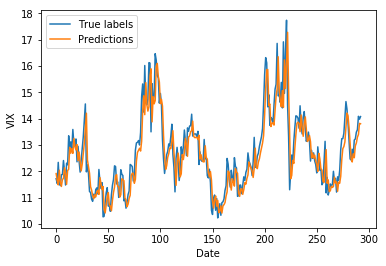

In [12]:
# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM( input_dim=1, output_dim=50, return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(output_dim=100, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(output_dim=1, activation='linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")

# train the model
model.fit(X_train, y_train, batch_size=512, nb_epoch=50, validation_split=0.05, verbose=1)

# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' 
      % (test_mse, len(y_test)))

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

# plot the results
fig = plt.figure()
line_1, = plt.plot(y_test + shifted_value, label = 'True labels')
line_2, = plt.plot(predicted_values + shifted_value, label = 'Predictions')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend(handles=[line_1, line_2])
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')

# save the result into txt file
#test_result = zip(predicted_values, y_test) + shifted_value
test_result = [x+shifted_value for x in zip(predicted_values, y_test)]
np.savetxt('output_result.txt', test_result)

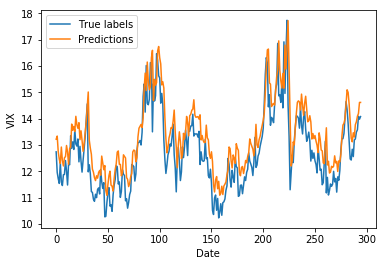

In [9]:
# plot the results
fig = plt.figure()
line_1, = plt.plot(y_test + shifted_value, label = 'True labels')
line_2, = plt.plot(predicted_values + shifted_value, label = 'Predictions')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend(handles=[line_1, line_2])
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')